In [1]:
import pandas as pd
import scipy.stats as st
import numpy as np
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score,average_precision_score
from sklearn.model_selection import RepeatedKFold
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Load samples:

In [2]:
pinfo = pd.read_csv('../../masked/patients_info.csv', index_col=0).sort_index()
meth = pd.read_csv('../../masked/meth.csv', index_col=0)
rna = (pd.read_csv('../../masked/rna.csv', index_col=0)+0.01).applymap(np.log2)
ssrna = pd.read_csv('../../masked/ssrna.csv', index_col=0)
dia = pd.read_csv('../../masked/dia.csv', index_col=0)
pp = pd.read_csv('../../masked/pp.csv', index_col=0)

df_sub = pinfo.loc[pinfo['Molecular_Subtype']=='XXX']

df_sub = df_sub[['Response']+\
                ['Feature 0','Feature 1','Feature 2',\
                 'Feature 3','Feature 4','Feature 5','Feature 6']].astype(float)

100-repeated 5-fold cross-validation:

In [3]:
kf = RepeatedKFold(n_splits=5, n_repeats=100, random_state=1)

fs = {}
fs['clin'] = ['Feature 0','Feature 1','Feature 2',]
fs['omics'] = ['Feature 0','Feature 1','Feature 2','Feature 3','Feature 4','Feature 5','Feature 6']

aucs = {}
for n_est in [50,100,200]:
    for l_rate in [0.05,0.1,0.2]:
        aucs[(n_est, l_rate)] = {}
        for f in fs.keys():
            aucs[(n_est, l_rate)][f] = []
aps = {}
for n_est in [50,100,200]:
    for l_rate in [0.05,0.1,0.2]:
        aps[(n_est, l_rate)] = {}
        for f in fs.keys():
            aps[(n_est, l_rate)][f] = []
    
for n_est in [50,100,200]:
    for l_rate in [0.05,0.1,0.2]:
        for train_index, test_index in kf.split(df_sub):
            X_train, X_test = df_sub.drop(columns='Response').iloc[list(train_index)], df_sub.drop(columns='Response').iloc[list(test_index)]
            y_train, y_test = df_sub['Response'].iloc[list(train_index)], df_sub['Response'].iloc[list(test_index)]

            for f in fs.keys():
                model = lgb.LGBMClassifier(random_state=1, n_estimators=n_est, learning_rate=l_rate)
                model.fit(X_train[fs[f]], y_train)
                X_test[f] = [i[1] for i in model.predict_proba(X_test[fs[f]])]
                aucs[(n_est, l_rate)][f].append(roc_auc_score(y_test,X_test[f]))
                aps[(n_est, l_rate)][f].append(average_precision_score(y_test,X_test[f]))
                
def best_params(res, fs):
    best_pdict = {}
    for i in fs:
        best_pdict[i] = pd.DataFrame(res).applymap(sum).T.sort_values(i).index[-1]
    return pd.concat([pd.DataFrame(res[best_pdict[i]]).melt().loc[pd.DataFrame(res[best_pdict[i]]).melt()['variable']==i] for i in fs])

Compare clinical model and multi-omics model:

Best (AUC) params for clin model:
# of trees: 200 
Learning rate: 0.05

Best (AUC) params for omics model:
# of trees: 100 
Learning rate: 0.05

Clin vs Omics:



(0.5, 1.02)

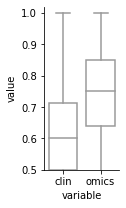

In [4]:
for i in fs.keys():
    print('Best (AUC) params for '+i+' model:')
    print('# of trees:',pd.DataFrame(aucs).applymap(sum).T[i].idxmax()[0], '\nLearning rate:',pd.DataFrame(aucs).applymap(sum).T[i].idxmax()[1])
    print()
    
f, ax = plt.subplots(figsize=[1.35,3])
df = best_params(aucs, ['clin','omics'])

print('Clin vs Omics:')
print()

sns.boxplot(df['variable'], df['value'], color='#ffffff', width=0.75)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylim([0.5,1.02])

Best (AUPRC) params for clin model:
# of trees: 200 
Learning rate: 0.05

Best (AUPRC) params for omics model:
# of trees: 100 
Learning rate: 0.05

Clin vs Omics:



(0.5, 1.02)

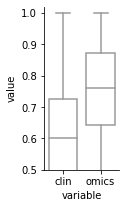

In [5]:
for i in fs.keys():
    print('Best (AUPRC) params for '+i+' model:')
    print('# of trees:',pd.DataFrame(aps).applymap(sum).T[i].idxmax()[0], '\nLearning rate:',pd.DataFrame(aps).applymap(sum).T[i].idxmax()[1])
    print()
        
        
f, ax = plt.subplots(figsize=[1.35,3])
df = best_params(aps, ['clin','omics'])

print('Clin vs Omics:')
print()

sns.boxplot(df['variable'], df['value'], color='#ffffff', width=0.75)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylim([0.5,1.02])

Retrain the optimized model using all samples and explain the model using SHAP:

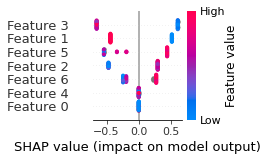

In [6]:
import shap
model = lgb.LGBMClassifier(random_state=1, \
                           n_estimators=pd.DataFrame(aucs).applymap(sum).T['omics'].idxmax()[0], \
                           learning_rate=pd.DataFrame(aucs).applymap(sum).T['omics'].idxmax()[1])
model.fit(df_sub[fs['omics']], df_sub['Response'])

model.booster_.save_model('./models/response.model')
model = lgb.Booster(model_file='./models/response.model')
model.params['objective'] = 'binary'

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(df_sub[fs['omics']])
plt.gca()

df_masked = df_sub[fs['omics']].copy()
df_masked.columns = ['Feature 0','Feature 1','Feature 2','Feature 3','Feature 4','Feature 5','Feature 6']
shap.summary_plot(shap_values[1], df_masked, plot_size=[2,2], show=False, plot_type="dot")